# Finetunen vom Elkulako/cryptobert Modell

## Import

In [44]:
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DebertaV2Tokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, EarlyStoppingCallback
import evaluate
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import transformers
import warnings

In [45]:
# Cuda pruefen
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [46]:
DATA_PATH = '../../data/processed/'

In [47]:
from sklearn.model_selection import train_test_split

# Nur Comments extrahieren
df_all_comments = pd.concat([df_comments_old, df_new_comments], ignore_index=True)
df_all_comments = df_all_comments[['id', 'text', 'label']].dropna()
df_all_comments['label'] = pd.to_numeric(df_all_comments['label'], errors='coerce')
df_all_comments = df_all_comments.dropna(subset=['label'])
df_all_comments['label'] = df_all_comments['label'].astype(int)

print(f"✅ Kommentardaten geladen: {len(df_all_comments)} Beispiele")


✅ Kommentardaten geladen: 276 Beispiele


## Train-Test-Split

In [48]:
# Stratifizierter Split
trainval_df, test_df = train_test_split(
    df_all_comments,
    test_size=0.2,
    stratify=df_all_comments["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 → 60/20/20 Split
    stratify=trainval_df["label"],
    random_state=42
)

# Indizes zurücksetzen
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("✅ Splits erzeugt:")
print(f"- Train: {len(train_df)}")
print(f"- Val:   {len(val_df)}")
print(f"- Test:  {len(test_df)}")


✅ Splits erzeugt:
- Train: 165
- Val:   55
- Test:  56


In [49]:
print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
print("Train labels:\n", train_df["label"].value_counts())


Train size: 165
Val size: 55
Test size: 56
Train labels:
 label
1    82
0    55
2    28
Name: count, dtype: int64


ab hier wird die class weight loss geaednert

In [50]:
from transformers import Trainer

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # ✅ **kwargs ergänzt
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [51]:
# 🔢 Manuelle Class Weights – hier z. B. stärkerer Fokus auf bearish
weights_tensor = torch.tensor([0.8, 1.0, 4.0], dtype=torch.float)
device = "cuda" if torch.cuda.is_available() else "cpu"

loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor.to(device))


## Modelltraining

Modell und Tokenizer laden

In [52]:
EXPERIMENTS_BASE_PATH = "../../models/experiments/"

MODEL_PATHS = {
    "cryptobert_comments": os.path.join(EXPERIMENTS_BASE_PATH, "cryptobert_comments")
}

for path in MODEL_PATHS.values():
    os.makedirs(path, exist_ok=True)


In [53]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATHS["cryptobert_comments"])
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATHS["cryptobert_comments"], num_labels=3)


In [54]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)


Tokenisierung der Splits

In [55]:
# Tokenisierung
train_ds = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
test_ds = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

# Format setzen – Korrekt pro Dataset!
train_ds = train_ds.rename_column("label", "labels")
val_ds = val_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 56/56 [00:00<00:00, 5948.16 examples/s]


Metriken

In [56]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }


Traininsargumente und Trainer

In [58]:
results = {}
lrs = [2e-5, 1e-5, 5e-6, 3e-6, 1e-6]

for lr in lrs:
    print(f"Starte Training für learning_rate = {lr}")

    output_dir = os.path.join(MODEL_PATHS["cryptobert_comments"], f"finetuned_lr_{lr}")
    logging_dir = os.path.join("../../logs/cryptobert_comments", f"lr_{lr}")
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(logging_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=7,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_dir=logging_dir,
        logging_strategy="epoch",
        report_to="none",
        remove_unused_columns=False,
        disable_tqdm=True
    )

    trainer = WeightedLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        loss_fn=loss_fn,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )



    start = time.time()
    trainer.train()
    end = time.time()

    logs = trainer.state.log_history
    epoch_logs = [log for log in logs if "eval_f1" in log]
    df = pd.DataFrame(epoch_logs)[["epoch", "eval_f1"]]
    df["learning_rate"] = lr

    results[lr] = {
        "f1_curve": df,
        "best_f1": df["eval_f1"].max(),
        "trainer": trainer
    }
    print(f"Training für learning_rate = {lr} abgeschlossen in {end - start:.2f} Sekunden.")

Starte Training für learning_rate = 2e-05


c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_18160\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 1.8089, 'grad_norm': 29.015541076660156, 'learning_rate': 1.7142857142857142e-05, 'epoch': 1.0}
{'eval_loss': 1.3230767250061035, 'eval_accuracy': 0.43636363636363634, 'eval_f1': 0.37938949938949945, 'eval_runtime': 0.4393, 'eval_samples_per_second': 125.2, 'eval_steps_per_second': 15.935, 'epoch': 1.0}
{'loss': 0.758, 'grad_norm': 41.74248504638672, 'learning_rate': 1.4285714285714287e-05, 'epoch': 2.0}
{'eval_loss': 1.1142686605453491, 'eval_accuracy': 0.5636363636363636, 'eval_f1': 0.47988993618640596, 'eval_runtime': 0.4364, 'eval_samples_per_second': 126.04, 'eval_steps_per_second': 16.041, 'epoch': 2.0}
{'loss': 0.3602, 'grad_norm': 10.92337703704834, 'learning_rate': 1.1428571428571429e-05, 'epoch': 3.0}
{'eval_loss': 1.1859315633773804, 'eval_accuracy': 0.5818181818181818, 'eval_f1': 0.49027777777777776, 'eval_runtime': 0.4461, 'eval_samples_per_second': 123.293, 'eval_steps_per_second': 15.692, 'epoch': 3.0}
{'loss': 0.1895, 'grad_norm': 14.120656967163086, 'learning_

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_18160\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.1573, 'grad_norm': 23.150514602661133, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.0}
{'eval_loss': 1.3705929517745972, 'eval_accuracy': 0.5636363636363636, 'eval_f1': 0.4820261437908497, 'eval_runtime': 0.4525, 'eval_samples_per_second': 121.538, 'eval_steps_per_second': 15.468, 'epoch': 1.0}
{'loss': 0.0498, 'grad_norm': 13.024577140808105, 'learning_rate': 7.1428571428571436e-06, 'epoch': 2.0}
{'eval_loss': 1.8040592670440674, 'eval_accuracy': 0.6181818181818182, 'eval_f1': 0.49494949494949503, 'eval_runtime': 0.4601, 'eval_samples_per_second': 119.546, 'eval_steps_per_second': 15.215, 'epoch': 2.0}
{'loss': 0.0173, 'grad_norm': 1.328643798828125, 'learning_rate': 5.7142857142857145e-06, 'epoch': 3.0}
{'eval_loss': 1.7626736164093018, 'eval_accuracy': 0.6181818181818182, 'eval_f1': 0.530026455026455, 'eval_runtime': 0.4563, 'eval_samples_per_second': 120.543, 'eval_steps_per_second': 15.342, 'epoch': 3.0}
{'loss': 0.018, 'grad_norm': 3.085421323776245, 'learning_ra

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_18160\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.0029, 'grad_norm': 0.20795807242393494, 'learning_rate': 4.2857142857142855e-06, 'epoch': 1.0}
{'eval_loss': 2.170097589492798, 'eval_accuracy': 0.6181818181818182, 'eval_f1': 0.5275613275613275, 'eval_runtime': 0.4702, 'eval_samples_per_second': 116.97, 'eval_steps_per_second': 14.887, 'epoch': 1.0}
{'loss': 0.0019, 'grad_norm': 1.6758583784103394, 'learning_rate': 3.5714285714285718e-06, 'epoch': 2.0}
{'eval_loss': 2.391385078430176, 'eval_accuracy': 0.6545454545454545, 'eval_f1': 0.5600421084292052, 'eval_runtime': 0.4688, 'eval_samples_per_second': 117.313, 'eval_steps_per_second': 14.931, 'epoch': 2.0}
{'loss': 0.0013, 'grad_norm': 0.0387895330786705, 'learning_rate': 2.8571428571428573e-06, 'epoch': 3.0}
{'eval_loss': 2.3320417404174805, 'eval_accuracy': 0.6545454545454545, 'eval_f1': 0.5600421084292052, 'eval_runtime': 0.4725, 'eval_samples_per_second': 116.41, 'eval_steps_per_second': 14.816, 'epoch': 3.0}
{'loss': 0.0013, 'grad_norm': 0.07231297343969345, 'learning_

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_18160\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.001, 'grad_norm': 0.059116918593645096, 'learning_rate': 2.571428571428571e-06, 'epoch': 1.0}
{'eval_loss': 2.3419084548950195, 'eval_accuracy': 0.6545454545454545, 'eval_f1': 0.5639880952380952, 'eval_runtime': 0.478, 'eval_samples_per_second': 115.07, 'eval_steps_per_second': 14.645, 'epoch': 1.0}
{'loss': 0.0008, 'grad_norm': 0.1334269493818283, 'learning_rate': 2.142857142857143e-06, 'epoch': 2.0}
{'eval_loss': 2.58882999420166, 'eval_accuracy': 0.6909090909090909, 'eval_f1': 0.588235294117647, 'eval_runtime': 0.476, 'eval_samples_per_second': 115.544, 'eval_steps_per_second': 14.706, 'epoch': 2.0}
{'loss': 0.0007, 'grad_norm': 0.025056103244423866, 'learning_rate': 1.7142857142857143e-06, 'epoch': 3.0}
{'eval_loss': 2.568540573120117, 'eval_accuracy': 0.6727272727272727, 'eval_f1': 0.5735425436917975, 'eval_runtime': 0.484, 'eval_samples_per_second': 113.638, 'eval_steps_per_second': 14.463, 'epoch': 3.0}
{'loss': 0.0007, 'grad_norm': 0.028553927317261696, 'learning_rat

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_18160\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.0005, 'grad_norm': 0.022303568199276924, 'learning_rate': 8.57142857142857e-07, 'epoch': 1.0}
{'eval_loss': 2.5795488357543945, 'eval_accuracy': 0.6363636363636364, 'eval_f1': 0.5345861867600997, 'eval_runtime': 0.4824, 'eval_samples_per_second': 114.005, 'eval_steps_per_second': 14.51, 'epoch': 1.0}
{'loss': 0.0005, 'grad_norm': 0.040816400200128555, 'learning_rate': 7.142857142857143e-07, 'epoch': 2.0}
{'eval_loss': 2.613929510116577, 'eval_accuracy': 0.6909090909090909, 'eval_f1': 0.5916484948743014, 'eval_runtime': 0.4701, 'eval_samples_per_second': 116.987, 'eval_steps_per_second': 14.889, 'epoch': 2.0}
{'loss': 0.0006, 'grad_norm': 0.023590287193655968, 'learning_rate': 5.714285714285714e-07, 'epoch': 3.0}
{'eval_loss': 2.640159845352173, 'eval_accuracy': 0.6727272727272727, 'eval_f1': 0.5735425436917975, 'eval_runtime': 0.4814, 'eval_samples_per_second': 114.258, 'eval_steps_per_second': 14.542, 'epoch': 3.0}
{'loss': 0.0006, 'grad_norm': 0.032695576548576355, 'learni

Plott fuer die Lernkurve

C:\Users\hp\AppData\Local\Temp\ipykernel_18160\460586369.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


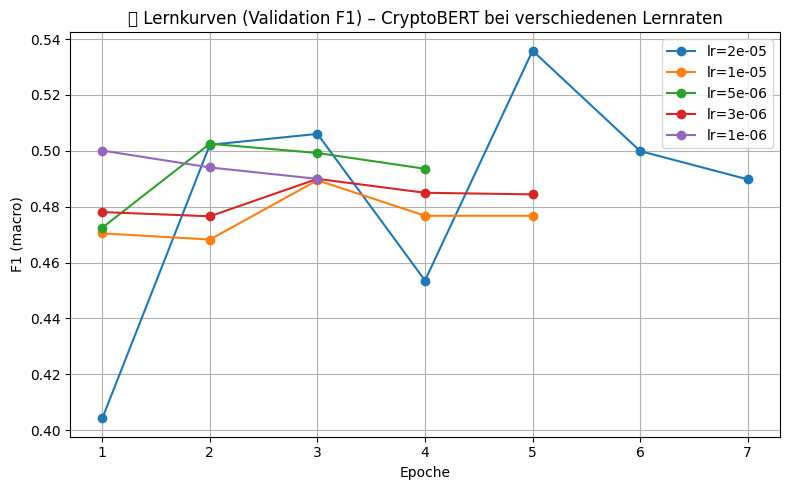

In [ ]:
plt.figure(figsize=(8, 5))

for lr, data in results.items():
    df = data["f1_curve"]
    plt.plot(df["epoch"], df["eval_f1"], marker="o", label=f"lr={lr}")

plt.title("📈 Lernkurven (Validation F1) – CryptoBERT bei verschiedenen Lernraten")
plt.xlabel("Epoche")
plt.ylabel("F1 (macro)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Beste Lernrate bestimmen
best_lr = max(results.items(), key=lambda x: x[1]["best_f1"])[0]
best_trainer = results[best_lr]["trainer"]

print(f"\n🏆 Beste Lernrate: {best_lr} mit F1 = {results[best_lr]['best_f1']:.4f}")



🏆 Beste Lernrate: 2e-05 mit F1 = 0.5358


Evaluation im finalen Testsplit

In [ ]:
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score

test_results = best_trainer.predict(test_ds)

y_pred = test_results.predictions.argmax(axis=1)
y_true = test_results.label_ids

# Hauptmetriken berechnen
f1_macro = f1_score(y_true, y_pred, average="macro")
kappa = cohen_kappa_score(y_true, y_pred)

print("\nEvaluation auf Testset:")
print("F1-Score (macro):", round(f1_macro, 4))
print("Cohen’s Kappa:   ", round(kappa, 4))
print("\nKlassifikationsreport:")
print(classification_report(y_true, y_pred))



Evaluation auf Testset:
F1-Score (macro): 0.4403
Cohen’s Kappa:    0.2088

Klassifikationsreport:
              precision    recall  f1-score   support

           0       0.51      0.54      0.53        37
           1       0.60      0.68      0.64        60
           2       0.25      0.11      0.15        18

    accuracy                           0.55       115
   macro avg       0.46      0.44      0.44       115
weighted avg       0.52      0.55      0.53       115



Falsche Vorhersagen

In [ ]:
wrong = [(i, p, t) for i, (p, t) in enumerate(zip(y_pred, y_true)) if p != t]
wrong_df = test_df.iloc[[i for i, _, _ in wrong]].copy()
wrong_df["predicted"] = [p for _, p, _ in wrong]
wrong_df["true"] = [t for _, _, t in wrong]

wrong_df[["text", "true", "predicted"]].head(10)


,text,true,predicted
1,Favourite ALTS for 2025? There's been much tal...,0,1
2,Would you take 100% chance of getting 600k or ...,0,1
5,India Strikes Crypto Exchange Bybit: Major Fin...,2,0
6,Traditional Investments v. Bitcoin The way I s...,0,1
7,"Bitcoin maxi posted ""Solana will be the first ...",0,1
13,Ethereum Foundation Reveals Leadership Shakeup...,2,1
14,Trip Report: Struggles of a new crypto user Hi...,2,1
17,"**Historical Bitcoin prices for today, Decembe...",1,0
18,!topics,1,0
19,Bitcoin surpasses 100k! New ath of 101.5k what...,1,0
